In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import pickle
from tabulate import tabulate
from functools import partial
import ctypes
from scipy.optimize import minimize, LinearConstraint, basinhopping
import matplotlib.pyplot as plt
import nlopt
from bgspy.likelihood import negll_c, negll, negll_numba, negll_fixmu_c
from bgspy.likelihood import negll_fixmu_numba, negll_free_c, negll_free_numba
from bgspy.likelihood import bounds, random_start_simplex, random_start_mutation, negll_mutation, bounds_mutation

In [3]:
def optim_summary(res, nt, nf):
    theta = res.x
    print(f"NLL: {res.fun}\npi0: {theta[0]}\n")
    offset = theta.size - nt * nf 
    if offset == 2:
        print(f"μ: {theta[1]}\nW = ")
    
    W = theta[offset:].reshape((nt, nf))
    print(tabulate(np.round(W, 3)))
    print(f"sums: {W.sum(axis=0)}")

def check_bounds(x, lb, ub):
    assert np.all((x >= lb) & (x <= ub))

In [4]:
    dat = pickle.load(open('../tests/likelihood_test_data.pkl', 'rb'))
    B, Y, w = dat['B'], dat['Y'], dat['w']

    nx, nw, nt, nf = B.shape
    nparams = nt * nf + 2

In [5]:
bounds(nt, nf, paired=True)
check_bounds(random_start_simplex(nt, nf), *bounds(nt, nf))

In [6]:
np.random.seed(1)

In [7]:
test_theta = np.array([1.33128476e-04, 1.99781458e-09, 8.62855908e-03, 2.01632113e-01,
       5.62221421e-01, 9.32838631e-03, 4.62330613e-01, 1.32512993e-01,
       9.18201833e-02, 3.32180143e-02, 3.02959135e-03, 6.38781967e-01,
       8.20186567e-02, 2.59546792e-01, 2.51440905e-01, 2.20800603e-01,
       4.26892028e-02])

numba_results = negll_numba(test_theta, Y, B, w)
c_results = negll_c(test_theta, Y, B, w)
np.testing.assert_almost_equal(c_results, numba_results)

In [8]:
random_start_mutation(nt, nf)

array([2.61229371e-04, 2.14363380e-11, 3.02402339e-08, 1.46841215e-08,
       2.14363380e-11, 3.02402339e-08, 1.46841215e-08, 2.14363380e-11,
       3.02402339e-08, 1.46841215e-08, 2.14363380e-11, 3.02402339e-08,
       1.46841215e-08, 2.14363380e-11, 3.02402339e-08, 1.46841215e-08])

In [9]:
start = random_start_mutation(nt, nf)
negll_free_c(start, Y, B, w)

6673144422509.813

In [10]:
negll_mutation(start, Y, B, w)

6673144422509.828

## Scipy no constraints

In [11]:
nll = partial(negll_mutation, Y=Y, logB=B, w=w)

In [12]:
bounds_mutation(nt, nf, paired=True)

[(0.0001, 0.001),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07),
 (1e-11, 1e-07)]

In [13]:
start = random_start_mutation(nt, nf)

minimize(nll, start, bounds=bounds_mutation(nt, nf, paired=True))

      fun: 919880395412.7035
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.17264638e+13,  5.33192164e+19,  7.83642949e+18,  5.60098838e+18,
        1.90408925e+19,  2.60147130e+18,  1.87687545e+18,  6.49134760e+18,
        8.99714347e+17,  6.33864645e+17,  3.15345392e+18,  4.78581254e+17,
        3.43893227e+17,  2.34359096e+18,  3.80646669e+17,  2.78169740e+17])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 34
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([1.e-03, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11,
       1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11, 1.e-11])

In [78]:
start

array([2.06783381e-04, 2.18023189e-08, 1.18345871e-11, 1.00133007e-08,
       2.18023189e-08, 1.18345871e-11, 1.00133007e-08, 2.18023189e-08,
       1.18345871e-11, 1.00133007e-08, 2.18023189e-08, 1.18345871e-11,
       1.00133007e-08, 2.18023189e-08, 1.18345871e-11, 1.00133007e-08])

## Scipy

In [10]:
def constraint_matrix(nt, nf, fixmu=False):
    nparams = nt*nf + 1 + int(not fixmu)
    A = np.zeros((nf, nparams))
    for i in range(nf):
        offset = 1 + int(not fixmu)
        start = offset + i*nt
        A[i, tuple(range(offset, nparams, nf))] = 1.
    return A

In [11]:
A = constraint_matrix(nt, nf, fixmu=True)
A.shape

(3, 16)

In [12]:
A[0, 1:].reshape((nt, nf))

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [13]:
def tol_vectors(n, tol1, tol2=None):
    if tol2 is None:
        tol2 = tol1
    return np.ones(n) - tol1, np.ones(n) + tol2

lb, ub = tol_vectors(nf, 1e-5)
constraint = LinearConstraint(A, lb, ub)
#constraint = LinearConstraint(A, np.ones(3), np.ones(3))
constraint

In [14]:
#nll2 = partial(negll_c, Y=Y, logB=B, w=w, bounds=bounds(nt, nf))
nll2 = partial(negll_c, Y=Y, logB=B, w=w)

In [15]:
x = random_start(nt, nf)

In [16]:
x

array([2.61229371e-04, 7.20352461e-08, 1.39177968e-04, 1.24603392e-01,
       5.70191291e-02, 4.38059527e-01, 1.48548572e-01, 5.24683867e-01,
       1.93116075e-01, 2.27460760e-01, 6.92274094e-03, 1.17887220e-01,
       1.59683217e-01, 2.76733971e-01, 2.50798000e-01, 3.39704060e-01,
       1.34640292e-01])

In [17]:
nll2(x)

2585097945963.104

In [18]:
negll(x, Y, B, w), negll_numba(x, Y, B, w)

(2585097945963.1064, 2585097945963.104)

In [19]:
constraint.lb, constraint.ub

(array([0.99999, 0.99999, 0.99999]), array([1.00001, 1.00001, 1.00001]))

In [20]:
constraint.A[2, 2:]

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.])

In [21]:
cons=({'type': 'eq','fun': lambda x: np.sum(A[0, :].dot(x) - 1.)},
      {'type': 'eq','fun': lambda x: np.sum(A[1, :].dot(x) - 1.)},
      #{'type': 'ineq','fun': lambda x: x },
      #{'type': 'ineq','fun': lambda x: 1-x},
     )

In [22]:
nll3 = partial(negll_fixmu_c, mu=1.1e-8, Y=Y, logB=B, w=w)

In [23]:
random_start(nt, nf, fixmu=True).shape

(16,)

In [24]:
random_start(nt, nf, fixmu=True)

array([4.91900330e-04, 1.30889212e-01, 3.47500552e-01, 7.38808708e-01,
       2.03059663e-01, 8.29376688e-02, 1.07339373e-01, 2.08274406e-03,
       3.92416116e-01, 1.04797343e-01, 1.56493957e-01, 2.74554893e-02,
       4.30152505e-02, 5.07474425e-01, 1.49690174e-01, 6.03932549e-03])

In [25]:
random_start(nt, nf, fixmu=True)

array([0.00047735, 0.15039134, 0.22695651, 0.1688456 , 0.32961863,
       0.30684905, 0.01618048, 0.02672247, 0.02753292, 0.2423861 ,
       0.41594577, 0.13632376, 0.34417996, 0.07732179, 0.30233777,
       0.22840786])

In [26]:
negll_fixmu_c(random_start(nt, nf, fixmu=True), 1e-8, Y, B, w)

1280965286637.8

In [31]:
constraint = LinearConstraint(A, lb, ub)
start = random_start(nt, nf, fixmu=True)

res = minimize(nll3, x0=start, 
               bounds=bounds(nt, nf, fixmu=True, paired=True), constraints=cons,
               method='SLSQP', options={'maxiter': 100_000, 'disp': True}, jac='3-point')
l, u = bounds(nt, nf, fixmu=True)
start, A.dot(start), l < start, start < u

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1292057735612.454
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1


(array([1.59695705e-04, 1.73855390e-01, 7.10643587e-02, 7.40822647e-03,
        2.77585247e-02, 1.76409852e-01, 2.86810942e-02, 1.11155974e-01,
        2.50704941e-01, 2.63207943e-01, 4.47720721e-01, 4.57627690e-01,
        3.68315619e-01, 2.39509391e-01, 4.41931589e-02, 3.32387118e-01]),
 array([1., 1., 1.]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]))

In [61]:
import multiprocessing, tqdm
ncores = 50
nchains = 200

def worker(start):
    constraint = LinearConstraint(A, lb, ub)
    start[0] = 1.9e-3
    res = minimize(nll3, x0=start, 
               bounds=bounds(nt, nf, fixmu=True, paired=True), constraints=cons,
               method='SLSQP', options={'maxiter': 100_000, 'disp': False}, jac='3-point')
    return res

starts = [random_start(nt, nf, fixmu=True) for _ in range(nchains)]
with multiprocessing.Pool(ncores) as p:
    res = list(tqdm.tqdm(p.imap(worker, starts), total=nchains))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 254.73it/s]


Note: COBYLA cannot handle bounds through `minimize()`'s `bounds` argument (it warns `Method cobyla cannot handle bounds`).

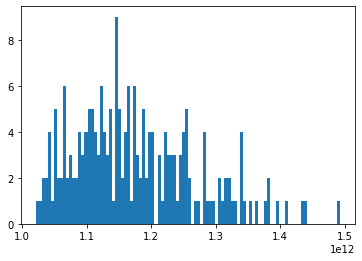

In [62]:
_ = plt.hist([x.fun for x in res], 100)

In [67]:
res[np.argmin([x.fun for x in res])].x[1:].reshape((nt, nf))

array([[0.04862449, 0.10238418, 0.08016482],
       [0.01248438, 0.04382719, 0.00618467],
       [0.17896572, 0.25161608, 0.35434727],
       [0.11957308, 0.51216319, 0.32944152],
       [0.64035233, 0.09000936, 0.22986172]])

In [36]:
constraint = LinearConstraint(A, lb, ub)
start = random_start(nt, nf, fixmu=True)
start[0] = 1.9e-3
#res = minimize(nll3, x0=start, 
#               bounds=bounds(nt, nf, fixmu=True, paired=True), constraints=constraint, method='cobyla', 
#               options={'catol': 1e-2, 'rhobeg': 1e-6, 'maxiter': 100_000, 'disp': True})

In [71]:
test

In [76]:
test = np.array([1.9e-3, 0.512, 0.828, 0.854, 0.052, 0.07 , 0.062,
                 0.001, 0.008, 0.015, 0.   , 0.021, 0.026, 0.435, 0.073, 0.043])

nll3(test)

1356928099090.2708

In [37]:
optim_summary(res, nt, nf)

AttributeError: 'list' object has no attribute 'x'

In [123]:
import multiprocessing, tqdm
ncores = 50
nchains = 10

def worker(start):
    constraint = LinearConstraint(A, lb, ub)
    start[0] = 1.9e-3
    res = minimize(nll3, x0=start, 
               bounds=bounds(nt, nf, fixmu=True, paired=True), constraints=constraint, method='cobyla', 
               options={'catol': 1e-2, 'rhobeg': 1e-6, 'maxiter': 100_000, 'disp': False})
    return res

starts = [random_start(nt, nf, fixmu=True) for _ in range(nchains)]
with multiprocessing.Pool(ncores) as p:
    res = list(tqdm.tqdm(p.imap(worker, starts), total=nchains))

  0%|                                                                                                                                                                                                                                                    | 0/10 [00:00<?, ?it/s]capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
  0%|                                                                                                                                                                                                                                                    | 0/10 [00:26<?, ?it/s]capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_r

KeyboardInterrupt: 

In [51]:
nlls = []
thetas = []
for i in range(50):
    res = minimize(nll3, x0=random_start(nt, nf, fixmu=True), bounds=bounds(nt, nf, fixmu=True, paired=True), 
               constraints=constraint, method='cobyla', options={'rhobeg': 1e-3}, jac='3-point')
    nlls.append(res.fun)
    thetas.append(res.x)

NameError: name 'nll3' is not defined

In [222]:
np.min(nlls)

941337003986.179

In [93]:
thetas[np.argmin(nlls)][:1], thetas[np.argmin(nlls)][1:].reshape((nt, nf))

(array([0.00453442]),
 array([[0.03251197, 0.15101332, 0.12190457],
        [0.0276984 , 0.04422929, 0.09609279],
        [0.27458412, 0.12930655, 0.00849492],
        [0.46847118, 0.64111908, 0.385355  ],
        [0.19672434, 0.02698448, 0.3836132 ]]))

In [77]:
res

     fun: 2218536307798.9067
     jac: array([-4.89129574e+11,  2.63679903e+19,  3.70643744e+12,  7.03909167e+11,
        5.27333655e+11,  1.53580310e+12,  3.12298799e+11,  2.36550488e+11,
        6.58696274e+11,  1.42327054e+11,  1.08465914e+11,  3.30934256e+11,
        7.34541251e+10,  5.57538673e+10,  1.73177242e+11,  4.00552100e+10,
        2.82026639e+10])
 message: 'Inequality constraints incompatible'
    nfev: 18
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([5.01609643e-02, 6.23979698e-08, 2.11675031e-01, 1.90871345e-01,
       7.20889077e-02, 2.39967938e-01, 2.31161314e-02, 1.36282384e-01,
       5.56817485e-04, 7.99514764e-02, 2.02972955e-01, 4.04996744e-01,
       8.32585729e-02, 2.53956283e-01, 1.42803470e-01, 6.22802474e-01,
       3.34699470e-01])

In [73]:
913543002497

913543002497

In [28]:
optim_summary(res, nt, nf)

NLL: 914164134247.83
pi0: 0.001480588452257598
μ: 2.9003137312273935e-10
W = 
-----  -----  -----
0.011  0.001  0.004
0.001  0.988  0.006
0.985  0.988  0.986
0.984  0.984  0.985
0.985  0.989  0.985
-----  -----  -----
sums: [2.96663603 3.94995404 2.96663602]


In [213]:
A.dot(random_start(nt, nf, fixmu=True))

array([1., 1., 1.])

In [219]:
class MyBounds:
    def __init__(self, A, nt, nf, xmin, xmax, tol=1e-5):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
        self.nt = nt
        self.nf = nf
        self.A = A
        self.tol = tol
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        constrained = np.all(np.abs(A.dot(x) - 1) < self.tol)
        golden = tmax and tmin and constrained
        if golden:
            print(x)
        return golden

basinhopping(nll3, x0=random_start(nt, nf, fixmu=True), T=1e11, niter=1000,
             stepsize=1e-8,
             accept_test=MyBounds(A, nt, nf, *bounds(nt, nf, fixmu=True)))

                        fun: nan
 lowest_optimization_result:       fun: nan
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [207]:
MyBounds(A, nt, nf, *bounds(nt, nf, fixmu=True))(x_new = random_start(nt, nf, fixmu=True))

True

## NLOpt

In [32]:
def fix_theta(theta, mu):
    new = np.empty(theta.size+1)
    new[0] = theta[0]
    new[1] = mu
    new[2:] = theta[1:]
    return new

In [33]:
start = random_start(nt, nf, fixmu=True)
(negll_c(fix_theta(start, 1e-8), Y, B, w),
 negll_numba(fix_theta(start, 1e-8), Y, B, w))

(1293169678966.8687, 1293169678966.8687)

In [34]:
negll_c(fix_theta(start, 1e-8), Y, B, w)

1293169678966.8687

In [36]:
def negll_optim(Y, logB, w):
    def func(theta, grad):
        mu = 1e-8
        return negll_fixmu_c(theta, mu, Y, logB, w)
    return func
    

In [38]:
nparams = nt*nf + 1
opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
#opt = nlopt.opt(nlopt.GN_ISRES, nparams)
#BB = B[..., 0][..., None]
BB = B
nll = negll_optim(Y, BB, w)

opt.set_min_objective(nll)
lb, ub = bounds(nt, nf, fixmu=True)


opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

In [39]:
def make_simplex_constraint(nt, nf, fixmu=False):
    def func(result, theta, grad):
        offset = 1 + int(not fixmu)
        C = theta[offset:].reshape((nt, nf)).sum(axis=0) - 1
        for i in range(nf):
            result[i] = C[i]
    return func

simplex_constraint = make_simplex_constraint(nt, nf, fixmu=True)
opt.add_equality_mconstraint(simplex_constraint, np.array([1e-9] * nf))

In [41]:
#opt.set_xtol_abs(np.array([1e-4] * nparams))
opt.set_ftol_abs(1e10)
#opt.set_stopval(923543002497)
#opt.set_maxeval(100000)
x = random_start(nt, nf, fixmu=True)
assert x.size == nparams

x = random_start(nt, nf, fixmu=True)
res = opt.optimize(x)

In [47]:
res[0], np.round(res[1:].reshape((nt, nf)), 3), opt.last_optimum_value()

(0.001,
 array([[0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.038, 0.014],
        [0.001, 0.104, 0.308],
        [0.999, 0.858, 0.678]]),
 958158377138.5476)

In [54]:
import multiprocessing, tqdm
ncores = 50
nchains = 100

def worker(start):
    res = opt.optimize(start)
    return res, opt.last_optimum_value()

starts = [random_start(nt, nf, fixmu=True) for _ in range(nchains)]
with multiprocessing.Pool(ncores) as p:
    res = list(tqdm.tqdm(p.imap(worker, starts), total=nchains))

  0%|                                                                                                                                                                                                                                                   | 0/200 [00:00<?, ?it/s]Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessing/pool.py", line 513, in _handle_workers
    cls._maintain_pool(ctx, Process, processes, pool, inqueue,
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessing/pool.py", line 337, in _maintain_pool
    Pool._repopulate_pool_static(ctx, Process, processes, pool,
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessi

KeyboardInterrupt: 

In [50]:
thetas, nlls = zip(*res)

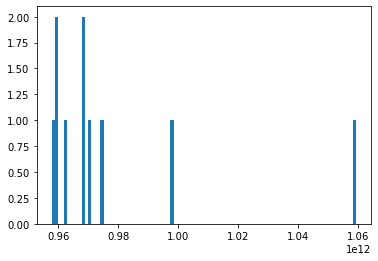

In [51]:
_ = plt.hist(nlls, 100)

In [52]:
min(nlls)

957831306890.0771

In [150]:
913543002497

913543002497

In [53]:
np.round(thetas[np.argsort(nlls)[0]][1:].reshape((nt, nf)), 3), thetas[np.argsort(nlls)[0]][0]

(array([[0.   , 0.   , 0.   ],
        [0.001, 0.002, 0.   ],
        [0.001, 0.044, 0.   ],
        [0.006, 0.013, 0.215],
        [0.992, 0.942, 0.785]]),
 0.001)

In [21]:
opt.set_xtol_abs(np.array([1e-4] * nparams))
#opt.set_maxeval(100000)
x = random_start(nt, nf, (-4, -1), (-11, -7))
assert x.size == nparams
nlls = []
thetas = []
for rep in range(100):
    x = random_start(nt, nf, (-4, -1), (-11, -7))
    thetas.append(opt.optimize(x))
    nlls.append(opt.last_optimum_value())
    

AssertionError: 

[]

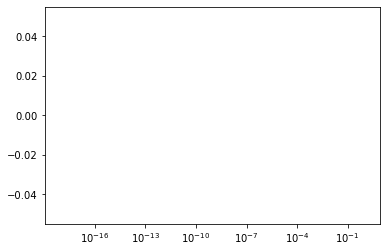

In [99]:
_ = plt.hist(nlls, 100)
plt.semilogx()

In [78]:
np.round(thetas[np.argmin(nlls)][2:].reshape((nt, nf)), 3)

array([[0.13 , 0.18 , 0.112],
       [0.112, 0.27 , 0.176],
       [0.241, 0.354, 0.133],
       [0.485, 0.135, 0.454],
       [0.032, 0.061, 0.125]])

In [46]:
np.round(theta_opt[2:].reshape((nt, nf)), 3), theta_opt[:2], opt.last_optimum_value() / 1e11

(array([[0.024, 0.189, 0.068],
        [0.241, 0.103, 0.322],
        [0.008, 0.072, 0.008],
        [0.092, 0.248, 0.37 ],
        [0.659, 0.388, 0.232]]),
 array([6.27060599e-02, 2.52663306e-08]),
 12.90574923998634)

In [190]:
optim_summary(res, nt, nf)

NLL: 2117434810847.348
pi0: 0.07523375854721732
μ: 5.960128848878832e-08
W = 
-----  -----  -----
0.095  0.044  0.29
0.311  0.012  0.507
0.057  0.767  0.027
0.031  0.08   0.171
0.506  0.097  0.004
-----  -----  -----
sums: [1. 1. 1.]


In [172]:
dir(res)

['final_simplex', 'fun', 'message', 'nfev', 'nit', 'status', 'success', 'x']

In [18]:
%%timeit
cnegloglik(theta, Y, B, w)

585 µs ± 7.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
alt_theta = np.empty((1 + nt*nf))
alt_theta[0] = theta[0]
alt_theta[1:] = W.flat

In [20]:
%%timeit
negll_numba(alt_theta, Y, B, w)

11.9 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%%timeit
negll(alt_theta, Y, B, w)

114 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
# C to numba
micro = 1e-6 # μ
milli = 1e-3 # m
579 * micro, 11.9 * milli,  1/(579 * micro / (11.9 * milli))

(0.000579, 0.0119, 20.552677029360968)

In [31]:
# numba to python (numpy)
11.9, 114, 114/11.9

(11.9, 114, 9.579831932773109)

In [26]:
negll_numba(alt_theta, Y, B, w), cnegloglik(theta, Y, B, w)

(1379202737130.2307, 1379202737130.2307)

In [10]:
xx = np.array([1.0112])
x = xx.ctypes.data_as(POINTER(c_double))
lib.test(x)

1.0112

In [12]:
B, Y, w = dat['B'], dat['Y'], dat['w']

In [13]:
B.shape

(2688, 6, 5, 3)

In [14]:
theta = np.array([1e-3, #0.8, 0.8, 0.1,
                         0.2,  0.1,  0.1,
                         0.01, 0.01, 0.1,
                         0.01, 0.04, 0.03,
                         0.3,  0.01, 0.03], dtype=float)

In [17]:
w

array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
       1.58489319e-08, 1.00000000e-07])

In [16]:
Y.dtype

dtype('float64')

In [19]:
nS, nD = np.array(Y[:, 0]), np.array(Y[:, 1])

In [ ]:
def negloglik(theta, Y, logB, w):
    nS = np.require(Y[:, 0], int, ['ALIGNED'])
    nD = np.require(Y[:, 1], int, ['ALIGNED'])
    theta = np.require(theta, float, ['ALIGNED'])
    nS_ptr = nS.ctypes.data_as(POINTER(c_double))
    nD_ptr = nD.ctypes.data_as(POINTER(c_double))
    theta_ptr = theta.ctypes.data_as(POINTER(c_double))
    logB_ptr = logB.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    w_ptr = w.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    lib.negloglik.argtypes = (POINTER(c_double), POINTER(c_double), POINTER(c_double), 
                             POINTER(c_double), POINTER(c_double), ctypes.POINTER(np.ctypeslib.c_intp), ctypes.POINTER(np.ctypeslib.c_intp))
    return lib.negloglik(theta_ptr, nS_ptr, nD_ptr, logB_ptr, w_ptr, logB.ctypes.shape, logB.ctypes.strides)
    
negloglik(theta, Y, B, w)

In [29]:
theta.ctypes